In [1]:
import numpy as np
import pandas as pd
from random import randrange
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
header = ['ID', 'Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape',
                       'Marginal_Adhesion', 'Single_Epithelial_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatin',
                       'Normal_Nucleoli', 'Mitoses', 'Class']
bc_df = pd.read_csv("../Downloads/breast-cancer-wisconsin.data", names=header)

In [34]:
bc_df.isnull().sum()

ID                             0
Clump_Thickness                0
Uniformity_of_Cell_Size        0
Uniformity_of_Cell_Shape       0
Marginal_Adhesion              0
Single_Epithelial_Cell_Size    0
Bare_Nuclei                    0
Bland_Chromatin                0
Normal_Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

In [35]:
for i,j in zip(bc_df.columns,(bc_df.values.astype(str) == '?').sum(axis = 0)):
    if j > 0:
        print(str(i) + ': ' + str(j) + ' missing')   

Bare_Nuclei: 16 missing


In [53]:
#Drop the 16 samples with missing bare nuclei information.
bc_df = bc_df[bc_df.Bare_Nuclei!='?']

In [54]:
bc_df=bc_df.astype(float)
bc_df['Class']=bc_df['Class'].map({2:0, 4:1})
#Dropping the irrelevant ID column 
bc_df=bc_df.drop(['ID'], axis=1)

In [57]:
bc_df.shape #683x10

(683, 10)

In [56]:
#class 2 = benign, class 4 = malignant
bc_df.tail()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
694,3.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,0
695,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0
696,5.0,10.0,10.0,3.0,7.0,3.0,8.0,10.0,2.0,1
697,4.0,8.0,6.0,4.0,3.0,4.0,10.0,6.0,1.0,1
698,4.0,8.0,8.0,5.0,4.0,5.0,10.0,4.0,1.0,1


In [87]:

class LogisticRegression:
    
    def __init__(self, percentage=0.5, lr=0.01, max_iter=10000, beta=0.99, reg_term=0):  # percentage = train/cv+test split
#        self.data = data
        self.percentage = percentage
        self.gradient_values, self.train_acc_values, self.cv_acc_values = [], [], []
        self.cv_acc, self.select_line, self.cv_acc_mean = 0, 0, 0
        self.learning_rate = lr
        self.max_iter = max_iter
        self.beta = beta
        self.reg_term = reg_term
        
    def predict_proba(self, X, theta):
        return self.sigmoid(np.dot(X, theta))

    def predict(self, X, theta):
        prediction = self.predict_proba(X, theta)
        predict_arr = []
        for i in prediction:
            if i>=0.5:
                predict_arr.append(1)
            else:
                predict_arr.append(0)

        return predict_arr

    def accuracy(self, predict_arr, y):
        correct = 0
        for i,j in zip(predict_arr, y):
            if i==j[0]:
                correct+=1
        return correct/len(y)  # accuracy = # tp+tn / total

    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def gradient(self, X, y, theta, lambdaa):  # lambdaa is regularization term
        N, D = len(X[0]), len(X[0])
        yh = self.sigmoid(np.dot(X, theta))
        grad = np.dot(X.T, yh-y) / N
        grad[1:] += lambdaa * theta[1:]
        return grad
    
    def fit(self, X, y, cv_X, cv_y, learning_rate=0.1, max_iter=10000, beta=0.99, reg_term=0.5):  # attempted termination condition - lack of improvement in cross validation set
        learning_rate = self.learning_rate
        max_iter = self.max_iter
        beta = self.beta
        reg_term = self.reg_term
        N, D = len(X[0]), len(X[0])
        theta = np.zeros((len(X[0]), 1))
        y = np.reshape(y, (-1,1))  # creates two-dimensional array
        cv_y = np.reshape(cv_y, (-1,1))
        iterate, cv_acc, prev_cv_acc, d_theta = 0, 0, 0, 0
        max_cv_acc = 0  # maximum cross validation accuracy - records thetas at highest cv_acc 
        best_theta = theta
        g = np.inf
        eps = 1e-2
        while (np.linalg.norm(g) > eps):  # can add in 'or cv_acc>=prev_cv_acc-0.03' to stop when gradient becomes too small, 0.03 gives buffer
            g = self.gradient(X, y, theta, reg_term)
            d_theta = (1-beta)*g + beta*d_theta  # momentum
            theta = theta-learning_rate*d_theta
            
            if iterate % 10 == 0:
                cv_pred = self.predict(cv_X, theta)
                prev_cv_acc = cv_acc
                cv_acc = self.accuracy(cv_pred, cv_y)
                train_pred = self.predict(X, theta)
                train_acc = self.accuracy(train_pred, y)
            if cv_acc >= max_cv_acc:  # checks if maximum accuracy thus far
                max_cv_acc = cv_acc
                best_theta = theta
                self.select_line = iterate
            iterate+=1
            self.gradient_values.append(np.linalg.norm(g))
            self.train_acc_values.append(train_acc)
            self.cv_acc_values.append(cv_acc)
#             if iterate % 100 == 0:
#                 print(np.linalg.norm(g)/len(X))
            if iterate > max_iter:  # since it may not always converge, place a hard ceiling on number of iterations
                break
        print(max_cv_acc)
        print(cv_acc)
        self.cv_acc = max_cv_acc
        self.cv_acc_mean = np.mean(self.cv_acc_values)
        return best_theta
    
    def get_test_acc(self, test_X, test_y, thetas):
        test_y = np.reshape(test_y, (-1,1))
        
        return self.accuracy(self.predict(test_X, thetas), test_y)

In [58]:
new_input = bc_df
new_input.insert(0, column='Bias', value=1)
new_input = new_input.sample(frac=1)  # randomly shuffles dataset

In [93]:
folds = 5
accuracies = []
mean_acc = []
learning_rate = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
for lr in learning_rate:
    for i in range(folds):

        start_bias = 0
        end_bias = 1
        if i>0:
            start_bias = 1  # to exclude last term in previous partition
        if i >= folds-1:
            end_bias = 0
        percentage = 1/folds
        length = len(new_input)
        test_set = new_input.iloc[int(percentage*(i)*length+start_bias):int(percentage*(i+1)*length), :]

        train_set_1 = new_input.iloc[int(percentage*(i+1)*length)+end_bias:length, :]
        train_set_2 = new_input.iloc[0:int(percentage*(i)*length), :]
        train_set = pd.concat([train_set_1, train_set_2])
        
        train_X = train_set.iloc[:, :-1]
        train_y = train_set.iloc[:, -1]

        test_X = test_set.iloc[:, :-1]
        test_y = test_set.iloc[:, -1]
        
        log_reg = LogisticRegression(percentage=0.6, lr = lr)
        log_reg.fit(train_X.values, train_y.values, test_X.values, test_y.values)
        accuracies.append(log_reg.cv_acc_mean)
        plt.figure()
        plt.plot(log_reg.train_acc_values, label = 'Training accuracy')
        plt.plot(log_reg.cv_acc_values, label='CV accuracy')
        plt.axvline(log_reg.select_line, color='r', label='Weights Selected')
        plt.plot([], [], ' ', label="Learning Rate: "+str(log_reg.learning_rate))
        plt.legend()
        plt.show()
   print("Average Accuracy: "+str(np.mean(accuracies)))
    mean_acc.append(np.mean(accuracies))


0.9632352941176471
0.9485294117647058
0.9779411764705882
0.9705882352941176
0.9703703703703703
0.9703703703703703
0.9705882352941176
0.9705882352941176
0.9779411764705882
0.9779411764705882
0.9632352941176471
0.9558823529411765
0.9705882352941176
0.9705882352941176
0.9703703703703703
0.9703703703703703
0.9779411764705882
0.9779411764705882
0.9779411764705882
0.9779411764705882
0.9632352941176471
0.9485294117647058
0.9779411764705882
0.9705882352941176
0.9703703703703703
0.9629629629629629
0.9779411764705882
0.9779411764705882
0.9779411764705882
0.9779411764705882
0.9632352941176471
0.9485294117647058
0.9852941176470589
0.9705882352941176
0.9703703703703703
0.9629629629629629
0.9779411764705882
0.9779411764705882
0.9779411764705882
0.9779411764705882
0.9632352941176471
0.9485294117647058
0.9852941176470589
0.9705882352941176
0.9777777777777777
0.9629629629629629
0.9852941176470589
0.9779411764705882
0.9779411764705882
0.9779411764705882
0.9632352941176471
0.9485294117647058
0.9852941176

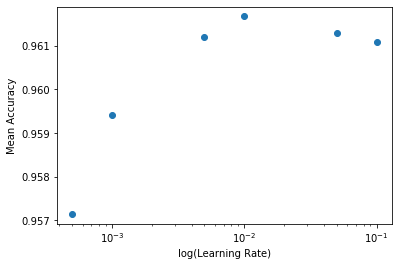

In [96]:
plt.plot(learning_rate, mean_acc, 'o')
plt.xscale("log")
plt.xlabel("log(Learning Rate)")
plt.ylabel("Mean Accuracy")
plt.show()
